# ДЗ: 


1. Сделать разведочный анализ данных, найти пропуски и выбросы. Примеры есть в ноутбуке EDA_AUTO из 4 задания.
2. Заполнить пропуски. Заполнить медианой или обучить линейную регрессию и заполнить ею пропуски. Если заполните линейной регрессией пропуски, то с помощью таблицы корреляций найдите второй признак, который имеет сильную взаимосвязь с первым признаком. Создаете отдельный датафрейм из этих признаков, исключаете пропуски (не удаляете), обучаете линейну регрессию. Затем прогнозируете на исключенных данных с пропусками и заполняете эти пропуски предсказанным значением.
3. Обучить множественную линейную регрессию. Она будет являться base line, т.е. базовая модель. С ней вы будете сравнивать другие модели.
4. Используя кроссвалидацию, подбор гиперпараметров обучить модели Lasso regression, Ridge Regression, ElasticNet (модель где Ridge + Lasso вместе используется), DecisionTreeRegressor, SVR, RandomForestRegressor
5. `alphas=[0.0001, 0.001,0.01, 0.1, 1, 10]` - для MultiTaskLassoCV, RidgeCV, и для ElasticNetCV.

`'l1_ratio':[0.01, 0.1, 0.5, 1, 5, 10, 15, 20]` - для ElasticNetCV
6. **для SVR и RandomForest:**
```python
param_grid = [{'regressor':[SVR()], 'preprocessing':[StandardScaler(), None],
              'regressor__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
               'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'regressor': [DecisionTreeRegressor()],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]},
              {'regressor': [RandomForestRegressor(n_estimators=100)],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]}]
```
7. **Если SVR обучается, то используем только этот набор параметров:**
```python
param_grid={
    'estimator__gamma': [0.001, 0.01],
    'estimator__C': [0.001, 0.01],
}
```

## Imports & vars

In [17]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, ElasticNetCV # Линейна регрессия, Ридж и Лассо
from sklearn.linear_model import LassoCV, RidgeCV, MultiTaskLassoCV # Ridge и Lasso Регрессия
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import make_scorer, r2_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column',None) 
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn import metrics

In [2]:
alphas = [[0.0001], [0.001], [0.01], [0.1], [1], [10]] # MultiTaskLassoCV, RidgeCV, и для ElasticNetCV
l1_ratio = [0.01, 0.1, 0.5, 1, 5, 10, 15, 20] # для ElasticNetCV

# для SVR и RandomForest
param_grid = [{'regressor':[SVR()], 'preprocessing':[StandardScaler(), None],
              'regressor__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
               'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'regressor': [DecisionTreeRegressor()],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]},
              {'regressor': [RandomForestRegressor(n_estimators=100)],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]}] 

# Если SVR обучается, то используем только этот набор параметров
# param_grid={
#     'estimator__gamma': [0.001, 0.01],
#     'estimator__C': [0.001, 0.01],
# }

In [3]:
df = pd.read_csv('data.csv')

In [4]:
inputs = ['KS4_GPA5_Qtg.PV', 'KS4_GPA5_TC_T1.PV', 'KS4_GPA5_Nst.PV'] # предикторы
outputs = ['KS4_GPA5_Nvd.PV', 'KS4_GPA5_Nnd.PV', 'KS4_GPA5_T4.PV', 'KS4_GPA5_Pk.PV'] # отклики, целевые признаки

## Разведочный анализ, заполнение пропусков (`корреляцией`)

In [5]:
print(df.isnull().sum())
print(df.isna().sum())

KS4_GPA5_Qtg.PV         0
KS4_GPA5_TC_T1.PV       0
KS4_GPA5_Nst.PV         0
KS4_GPA5_Nvd.PV         0
KS4_GPA5_Nnd.PV      2001
KS4_GPA5_T4.PV          0
KS4_GPA5_Pk.PV          0
dtype: int64
KS4_GPA5_Qtg.PV         0
KS4_GPA5_TC_T1.PV       0
KS4_GPA5_Nst.PV         0
KS4_GPA5_Nvd.PV         0
KS4_GPA5_Nnd.PV      2001
KS4_GPA5_T4.PV          0
KS4_GPA5_Pk.PV          0
dtype: int64


```столбец "KS4_GPA5_Nnd.PV" содержит 2001 пустую строку, изучим корреляцию с другими столбцами для выбора предиктора и построим предсказательную модель```

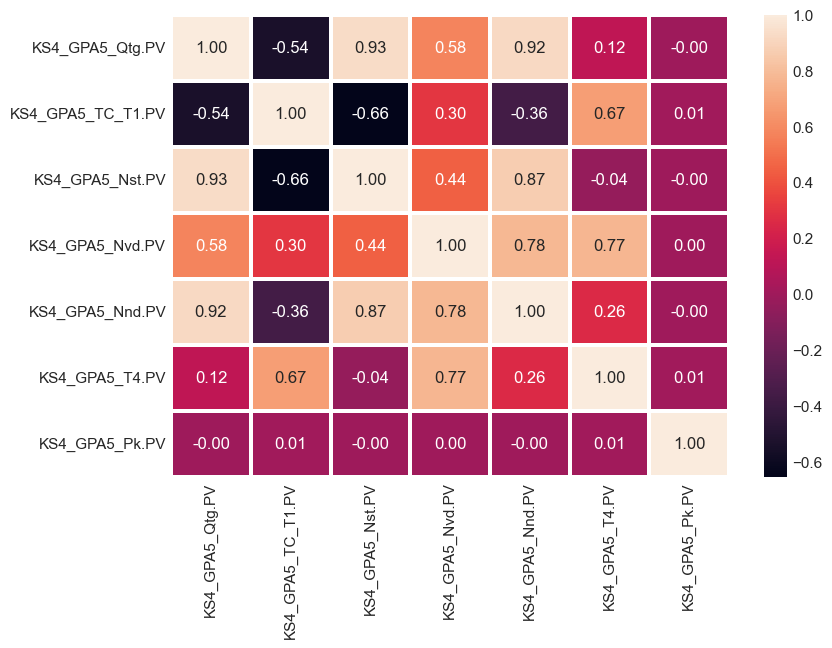

In [6]:
corr = df.corr()
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

In [7]:
X = df['KS4_GPA5_Qtg.PV'].values
y = df['KS4_GPA5_Nnd.PV'].values

nan_Indexes = np.argwhere(np.isnan(y))
# Removing multiple elements based on index positions
X = np.delete(X, nan_Indexes)
y = np.delete(y, nan_Indexes)

In [8]:
poly_features = PolynomialFeatures(degree = 4) # полиномиальная регрессия
X_poly = poly_features.fit_transform(X.reshape(-1,1))

# разбиение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.25, random_state = 22) 

poly_reg_model = LinearRegression().fit(X_train, y_train)
poly_reg_model.score(X_train, y_train), poly_reg_model.score(X_test, y_test)

(0.8722344728230169, 0.8770792842823278)

### Заполнение пропусков с помощью предиктора

In [9]:
for i in nan_Indexes:
    df['KS4_GPA5_Nnd.PV'][i] = poly_reg_model.predict(poly_features.fit_transform(df['KS4_GPA5_Qtg.PV'].values[i].reshape(-1,1)))

df['KS4_GPA5_Nnd.PV']

0        912.161426
1        914.203027
2        914.924512
3        915.881055
4        916.435645
            ...    
29707    914.571973
29708    913.476074
29709    913.913086
29710    913.895508
29711    914.839062
Name: KS4_GPA5_Nnd.PV, Length: 29712, dtype: float64

In [10]:
print(df.isna().sum()) # ТЕПЕРЬ ПРОПУСКОВ НЕТ

KS4_GPA5_Qtg.PV      0
KS4_GPA5_TC_T1.PV    0
KS4_GPA5_Nst.PV      0
KS4_GPA5_Nvd.PV      0
KS4_GPA5_Nnd.PV      0
KS4_GPA5_T4.PV       0
KS4_GPA5_Pk.PV       0
dtype: int64


## Base line - множественная линейная регрессия

In [11]:
X = df[inputs].values
y = df[outputs].values

multyline_regressor = LinearRegression()

In [99]:
# разбиение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 35) 
multyline_regressor.fit(X_train, y_train)
multyline_regressor.score(X_train, y_train), multyline_regressor.score(X_test, y_test)

(0.882692100347658, 0.6488335605972715)

## [Кроссвалидация](https://academy.yandex.ru/handbook/ml/article/kross-validaciya) и подбор `гиперпараметров` 

In [20]:
def find_best(estimator_model, params):
    # включает в себя кроссвалидацию
    grid_search = GridSearchCV(estimator = estimator_model, param_grid = params, cv = 5, n_jobs = -1)
    grid_search.fit(X_train, y_train)

    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    return grid_search


## Lasso Regression

In [21]:
lasso_model = MultiTaskLassoCV()
lasso_params = {'alphas': alphas}

lasso_best = find_best(estimator_model = lasso_model, params = lasso_params)

Best Accuracy: 88.26 %
Best Parameters: {'alphas': [0.0001]}


## Ridge Regression

In [22]:
ridge_model = RidgeCV()
ridge_params = {'alphas': alphas}

ridge_best = find_best(estimator_model = ridge_model, params = ridge_params)

Best Accuracy: 88.26 %
Best Parameters: {'alphas': [0.0001]}


## ElasticNet (Ridge + Lasso)

In [23]:
elnet_model = MultiTaskElasticNetCV()
elnet_params = {'alphas': alphas,
                'l1_ratio': l1_ratio}

elnet_best = find_best(estimator_model = elnet_model, params = elnet_params)

Best Accuracy: 88.26 %
Best Parameters: {'alphas': [0.0001], 'l1_ratio': 1}


## DecisionTreeRegressor

In [24]:
dtree_model = DecisionTreeRegressor()
dtree_params = {'max_features': [1, 2, 3]}

dtree_best = find_best(estimator_model = dtree_model, params = dtree_params)

Best Accuracy: 98.64 %
Best Parameters: {'max_features': 3}


## SVR __запускать на свой страх и риск ^^__

In [85]:
svr_model = MultiOutputRegressor(SVR())
svr_params = {
    'estimator__gamma': [0.001, 0.01],
    'estimator__C': [0.001, 0.01],
}

svr_best = find_best(estimator_model = svr_model, params = svr_params)

Best Accuracy: 51.72 %
Best Parameters: {'estimator__C': 0.01, 'estimator__gamma': 0.01}


## RandomForestRegressor

In [25]:
rndForest_model = RandomForestRegressor(n_estimators=100)
rndForest_params = {'max_features': [1, 2, 3]}

rndForest_best = find_best(estimator_model = rndForest_model, params = rndForest_params)

Best Accuracy: 99.26 %
Best Parameters: {'max_features': 2}


## `Сравним все модели на X_test, y_test`

In [86]:
models = {'base_line': multyline_regressor,
           'Lasso': lasso_best,
           'Ridge': ridge_best,
           'ElasticNet': elnet_best,
           'DecisionTree': dtree_best,
           'SVR': svr_best,
           'RandomForest': rndForest_best}

In [92]:
def test(models):
    results = {}
    for i in models:
        test_score = []
        test_score.append(models[i].score(X_test, y_test))
        results[i] = test_score
    return pd.DataFrame(results)

In [93]:
test(models)

,base_line,Lasso,Ridge,ElasticNet,DecisionTree,SVR,RandomForest
0,0.648834,0.648817,0.648833,0.648817,0.739841,0.379661,0.744782
